# write a quick loop in jax to minimise MDN logprob

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
from tqdm import tqdm
import optax

from tensorflow_probability.substrates.jax import distributions as tfd


from typing import Sequence, Any, Callable
Array = Any

import numpy as np
import flax.linen as nn
import matplotlib.pyplot as plt
import cloudpickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

2025-02-04 23:10:39.678247: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-04 23:10:39.678408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-04 23:10:39.840742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 23:10:51.284148: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
cd /home/makinen/repositories/des-hybrid/

/home/makinen/repositories/des-hybrid


/home/makinen/venvs/epe/lib64/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
file = np.load("/home/makinen/repositories/des-hybrid/cls_train_test_sys.npz")

params_Tru_train = file["params_train"]
cls_train = file["cls_train"]

params_Tru_LFI = file["params_lfi"]
cls_lfi = file["cls_lfi"]

params_Tru_test = file["params_test"]
cls_test = file["cls_test"]


params_Tru_sys = file["params_sys"]
cls_sys = file["cls_sys"]


# calculate scaling for standardisation
S1_cls = cls_train.mean(0)
S2_cls = (cls_train**2).mean(0)

mean_cl = S1_cls
std_cl = np.sqrt(S2_cls - mean_cl**2)
cut_idx = 22

def slice_cls(cls):
    cls = (cls - mean_cl) / std_cl
    cls = cls[:, :, 0, 0::3, :cut_idx]
    return cls.reshape(cls.shape[0], -1)

def slice_cls_single(cls):
    cls = (cls - mean_cl) / std_cl
    cls = cls[:, 0, 0::3, :cut_idx]
    return cls.reshape(cls.shape[0], -1)



# cut out w < -1
# mask = (params_Tru_train[:, 2] < -1.0)
# params_Tru_train = params_Tru_train[mask]
# cls_train = cls_train[mask]

# mask = (params_Tru_test[:, 2] < -1.0)
# params_Tru_test = params_Tru_test[mask]
# cls_test = cls_test[mask]

# mask = (params_Tru_LFI[:, 2] < -1.0)
# params_Tru_LFI = params_Tru_LFI[mask]
# cls_lfi = cls_lfi[mask]

In [3]:
params_Tru_train[:, 2]

array([0.4190775 , 0.49128956, 0.59896696, ..., 0.5913988 , 0.5266192 ,
       0.46922863], dtype=float32)

In [4]:
cls_train.shape

(9216, 10, 2, 4, 28)

In [6]:
# save cls stats
np.savez("/home/makinen/repositories/des-hybrid/cls_utils/cls_statistics_for_normalisation",
         S1_cls=S1_cls,
         S2_cls=S2_cls,
         mean_cl=mean_cl,
         std_cl=std_cl,
         cut_idx=cut_idx,
)

In [7]:
cls_train.shape

(9216, 10, 2, 4, 28)

In [10]:
# define model
from network.new_epe_code import *


class Cls_MLP_Network(nn.Module):
    hidden_channels: list
    n_summaries: int
    act: Callable = nn.relu
    sigmoid_out: bool = False

    def setup(self):
        self.embed = nn.Dense(450)
        self.embed2 = nn.Dense(500)
        #self.layernorm = nn.LayerNorm()
        self.net = MLP(self.hidden_channels + (self.n_summaries,), act=self.act)

    def __call__(self, x):

        # cut down mass value
        x = slice_cls_single(x)
        x = x.reshape(-1)
        x = self.embed(x)
        # x = self.layernorm(x)
        #x = self.embed2(x)
        x = self.act(x)
        x = self.net(x)

        if self.sigmoid_out:
            x = nn.sigmoid(x)

        return x



class ClsModel(EPEModel, nn.Module):
    n_summaries: int
    n_params: int = 3
    n_components: int = 4
    # mlp: nn.Module
    

    def setup(self):
        self.mdn = MDN(
                        hidden_channels=[100],
                        n_components=self.n_components,
                        n_dimension=self.n_params,
                        act=nn.relu)
        
        self.mlp = Cls_MLP_Network(
                        hidden_channels=[256]*10,
                        n_summaries=self.n_summaries,
                        act=smooth_leaky,
                        sigmoid_out=False)

    def get_embed(self, x):
        return self.mlp(x)

    def log_prob(self, x, theta):
        x = self.mlp(x)
        return self.mdn(x, theta) 

    #@nn.compact
    
    def __call__(self, x, theta):
        x = self.mlp(x)
        #return x
        return self.mdn(x, theta)


    

In [49]:
key = jr.PRNGKey(4)
cls_single_shape = (10, 2, 4, 28,)


model = ClsModel(n_summaries=10)

w = model.init(key, cls_train[0], jnp.ones(3,), method=model.log_prob)

In [50]:
model.apply(w, jr.normal(key, shape=cls_single_shape)*1e-7, jnp.ones(3,))

Array(-5.147239, dtype=float32)

In [51]:
model.apply(w, jr.normal(key, shape=cls_single_shape)*1e-7, jnp.ones(3,), method=model.log_prob)

Array(-5.147239, dtype=float32)

In [52]:
batch_size = 128
n_train = cls_train.shape[0]

remainder = batch_size * (cls_test.shape[0] // batch_size)

n_params = 3

data_ = cls_train.reshape((-1, batch_size,) + cls_single_shape)
theta_ = params_Tru_train.reshape(-1, batch_size, n_params)

# reshape the test data into batches
data_test = cls_test[:remainder].reshape((-1, batch_size,) + cls_single_shape)
theta_test = params_Tru_test[:remainder].reshape(-1, batch_size, n_params)

In [53]:
#@title training loop <font color='lightblue'>[run me]</font>

def noise_simulator(key, data):
    """add in gaussian noise to the Cls for training"""
    return data + jr.normal(key, shape=(cls_single_shape)) * 1e-3 * std_cl

@jax.jit
def mse_loss(w, x_batched, theta_batched):

    def fn(x, theta):
       preds = model.apply(w, x)
       return preds

    preds_batched = jax.vmap(fn)(x_batched, theta_batched)
    return jnp.mean((preds_batched - theta_batched)**2)

@jax.jit
def logprob_loss(w, x_batched, theta_batched):

    def fn(x, theta):
       logp = model.apply(w, x, theta)
       return logp

    logp_batched = jax.vmap(fn)(x_batched, theta_batched)
    return -jnp.mean(logp_batched)


# init model again
w = model.init(key, cls_train[0], jnp.ones(3,))

# # Clip gradients at max value, and evt. apply weight decay
transf = [optax.clip(2.0)]
# transf.append(optax.add_decayed_weights(1e-4))
tx = optax.chain(
    *transf,
    optax.adam(learning_rate=1e-6)
)
#tx = optax.adam(learning_rate=1e-5)
opt_state = tx.init(w)
loss_grad_fn = jax.value_and_grad(logprob_loss)


epochs = 1000

# this is a hack to make the for-loop training much faster in jax
def body_fun(i, inputs):
    w,loss_val, opt_state, _data, _theta, key = inputs
    x_samples = _data[i]
    y_samples = _theta[i]

    # apply noise simulator
    keys = jr.split(key, x_samples.shape[0])
    x_samples = jax.vmap(noise_simulator)(keys, x_samples)


    loss_val, grads = loss_grad_fn(w, x_samples, y_samples)
    updates, opt_state = tx.update(grads, opt_state, w)
    w = optax.apply_updates(w, updates)

    return w, loss_val, opt_state, _data, _theta, key


def val_body_fun(i, inputs):
    w,loss_val, _data, _theta, key = inputs
    x_samples = _data[i]
    y_samples = _theta[i]

    # apply noise simulator
    keys = jr.split(key, x_samples.shape[0])
    x_samples = jax.vmap(noise_simulator)(keys, x_samples)

    loss_val, grads = loss_grad_fn(w, x_samples, y_samples)

    return w, loss_val, _data, _theta, key


key = jax.random.PRNGKey(999)

losses = jnp.zeros(epochs)
val_losses = jnp.zeros(epochs)
loss_val = 0.
val_loss_value = 0.
lower = 0
upper = n_train // batch_size

pbar = tqdm(range(epochs), leave=True, position=0)
counter = 0

for j in pbar:
      key,rng = jax.random.split(key)

      # shuffle data every epoch
      randidx = jr.permutation(key, jnp.arange(theta_.reshape(-1, n_params).shape[0]), independent=True)
      _data = data_.reshape((-1,) + cls_single_shape)[randidx].reshape((-1, batch_size,) + cls_single_shape)
      _theta = theta_.reshape(-1, n_params)[randidx].reshape(-1, batch_size, n_params)

      #print(_data.shape)

      inits = (w, loss_val, opt_state, _data, _theta, key)

      w, loss_val, opt_state, _data, _theta, key = jax.lax.fori_loop(lower, upper, body_fun, inits)

      losses = losses.at[j].set(loss_val)


      # do validation set
      key,rng = jr.split(key)
      inits = (w, loss_val, data_test, theta_test, key)
      w, val_loss_value, data_test, theta_test, key = jax.lax.fori_loop(0, data_test.shape[0], val_body_fun, inits)
      val_losses = val_losses.at[j].set(val_loss_value)

      #val_losses.append(val_loss)
      pbar.set_description('epoch %d loss: %.5f  val loss: %.5f'%(j, loss_val, val_loss_value))

      counter += 1


epoch 999 loss: -5.08308  val loss: -5.03244: 100%|██████████| 1000/1000 [01:59<00:00,  8.39it/s]


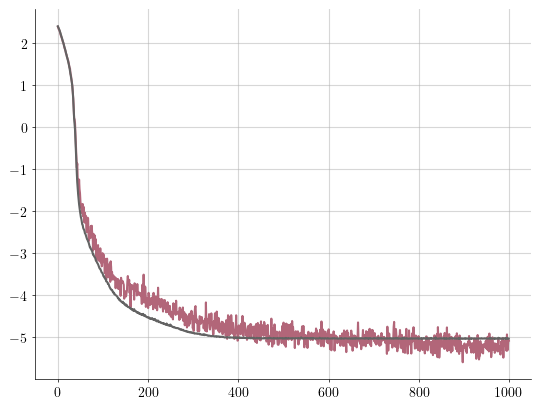

In [54]:
plt.plot(losses)
plt.plot(val_losses)
plt.show()

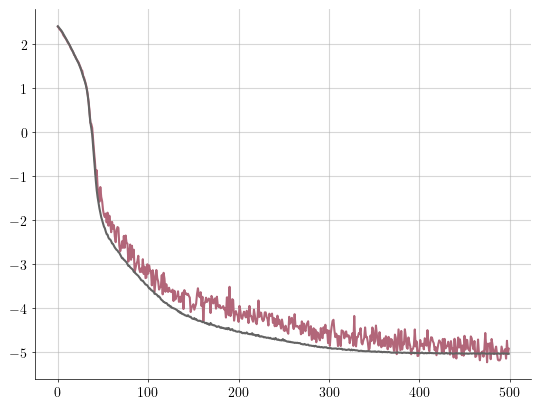

In [43]:
plt.plot(losses)
plt.plot(val_losses)
plt.show()

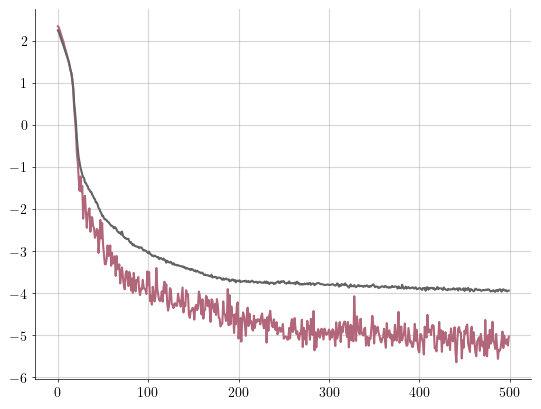

In [19]:
plt.plot(losses)
plt.plot(val_losses)
plt.show()

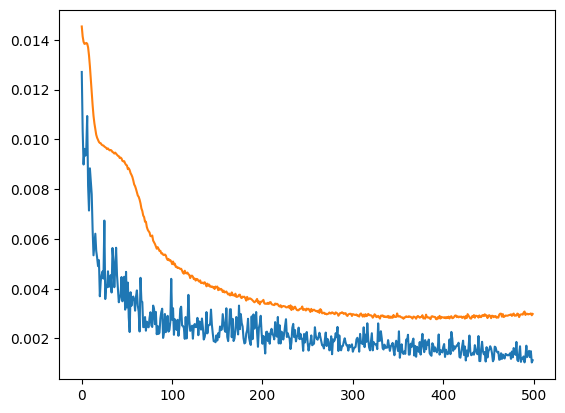

In [217]:
plt.plot(losses)
plt.plot(val_losses)
plt.show()

In [218]:
_data.shape, _theta.shape

((144, 64, 10, 2, 4, 28), (144, 64, 3))

In [219]:
data_test.shape

(47, 64, 10, 2, 4, 28)

In [55]:
appl = lambda d: model.apply(w, d, method=fullModel.get_embed)
preds_test = jax.vmap(appl)(cls_test)
preds_lfi = jax.vmap(appl)(cls_lfi)
preds_train = jax.vmap(appl)(cls_train)
preds_sys = jax.vmap(appl)(cls_sys)

In [56]:
preds_test.shape

(3024, 10)

In [57]:
normed_summaries = (preds_lfi - preds_lfi.mean(0)) / preds_lfi.std(0)

In [58]:
#normed_summaries = (normed_summaries - normed_summaries.mean(0)) / normed_summaries.std(0)

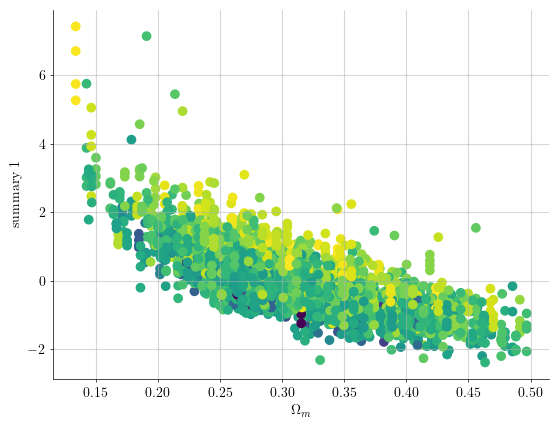

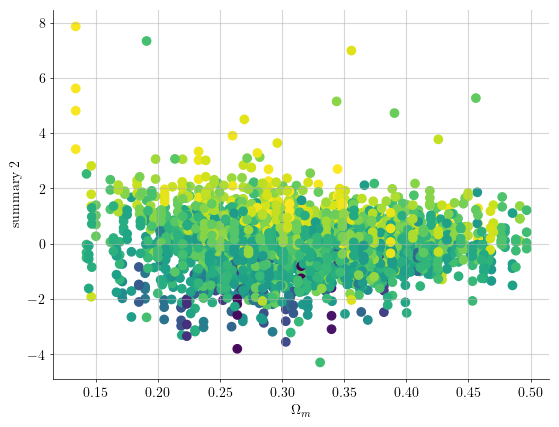

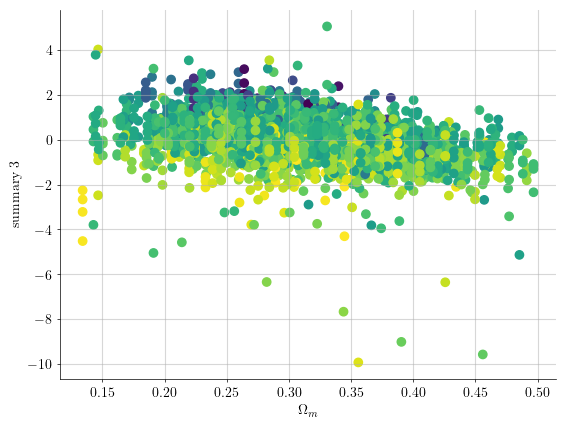

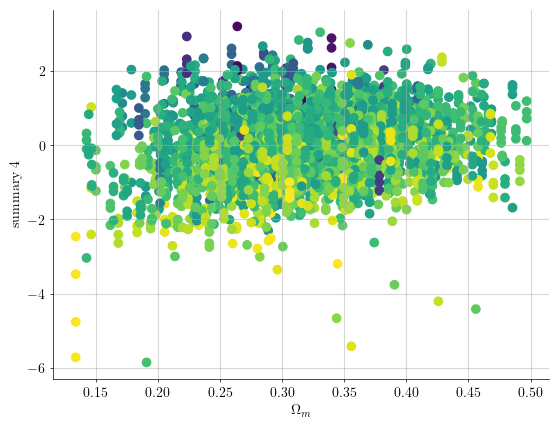

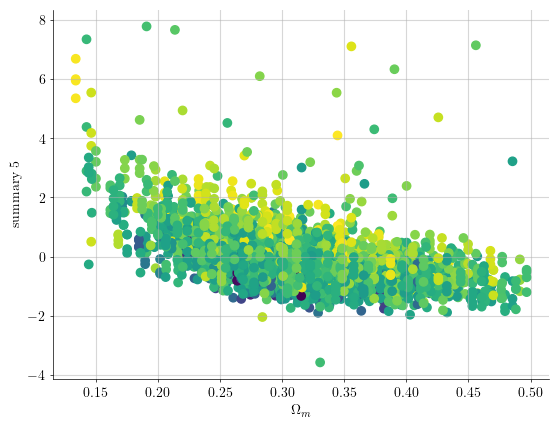

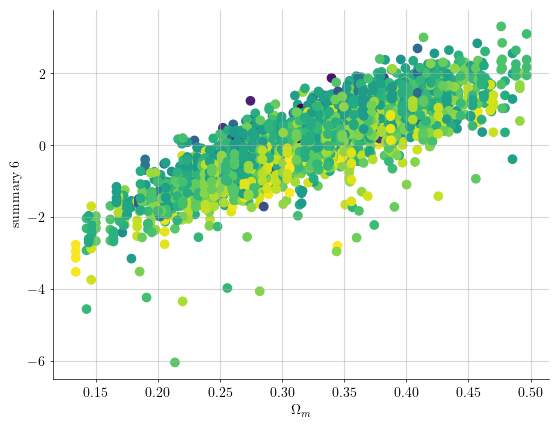

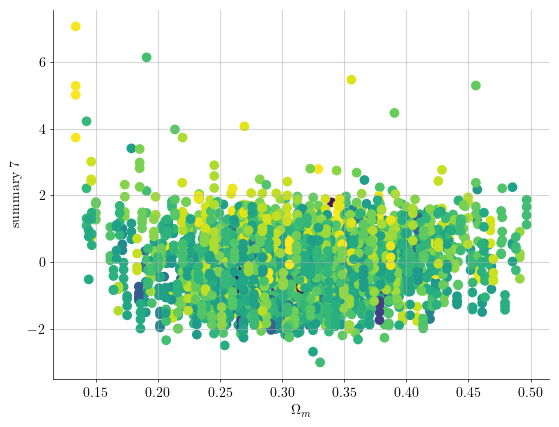

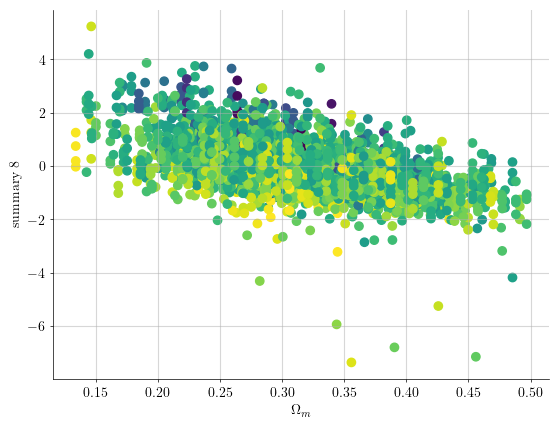

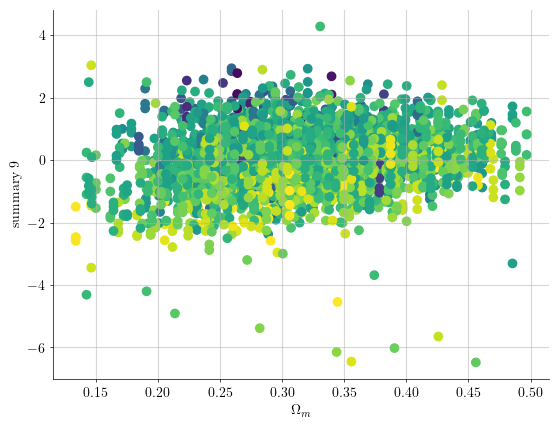

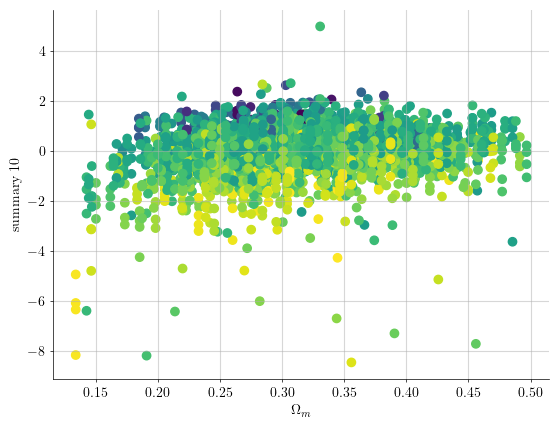

In [59]:
for i in range(preds_test.shape[1]):
    plt.scatter(params_Tru_LFI[:, 0], normed_summaries[:, i], c=params_Tru_LFI[:, 2])
    plt.xlabel(r"$\Omega_m$")
    plt.ylabel("summary %d"%(i+1))
    plt.show()

In [60]:
save_obj(w, "/data103/makinen/des_results/cls_net/w_cls_compress_mdn_10summaries.pkl")

In [61]:
pwd

'/home/makinen/repositories/des-hybrid'

In [62]:
np.savez("/home/makinen/repositories/des-hybrid/vanilla-comparison/summaries_mdn_pred_cls_04_02",
         summs_lfi=preds_lfi,
         params_lfi=params_Tru_LFI,
         summs_test=preds_test,
         params_test=params_Tru_test,
         summs_sys=preds_sys,
         params_sys=params_Tru_sys,
         summs_train=preds_train,
         params_train=params_Tru_train
         )

In [139]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split




#X, y = make_regression(n_samples=200, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(preds_lfi, 
                                                     params_Tru_LFI,
                                                    random_state=1)
regr = MLPRegressor(hidden_layer_sizes=(100,)*3,
                    learning_rate_init=1e-4,
                    #learning_rate='invscaling',
                    activation='relu', solver='adam',
                    validation_fraction=0.2,
                    early_stopping=True,
    random_state=2, max_iter=3000).fit(X_train, y_train)

print(regr.predict(X_test[:2]))
print(regr.score(X_test, y_test))

reg_preds_test = regr.predict(preds_test)

[[ 0.26225916  0.89582485 -0.991586  ]
 [ 0.21302865  1.0554864  -0.6194455 ]]
0.6627854108810425


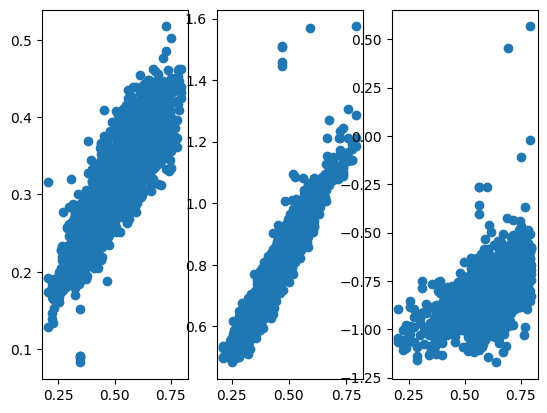

In [140]:
plt.subplot(131)
plt.scatter(params_Tru_test[:, 0], reg_preds_test[:, 0])
# plt.scatter(params_Tru_LFI_S8[:, 0], reg_preds_LFI[:, 0])
#plt.scatter(params_Tru_LFI_S8[:, 0], preds_LFI[:, 0])

plt.subplot(132)
plt.scatter(params_Tru_test[:, 1], reg_preds_test[:, 1])
# plt.scatter(params_Tru_LFI_S8[:, 1], reg_preds_LFI[:, 1])

plt.subplot(133)
plt.scatter(params_Tru_test[:, 2], reg_preds_test[:, 2])
# plt.scatter(params_Tru_LFI_S8[:, 2], reg_preds_LFI[:, 2])